In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc

In [2]:
beningList1 = os.listdir('D:/Dataet/Tet/bening/')
beningList2 = os.listdir('D:/Dataet/Train/bening/')
malignantList1 = os.listdir('D:/Dataet/Tet/Malignant/')
malignantList2 = os.listdir('D:/Dataet/Train/Malignant/')

In [3]:
SIZE = 224

In [4]:
from cv2 import imread, resize

def create_dataset(x, y, path, files, type_):
    for i in range(len(files)):
        img = imread(path + files[i])
        img = resize(img, (SIZE, SIZE))
        X.append(img)
        y.append(type_)

In [5]:
from sklearn.utils.class_weight import compute_class_weight
from keras.utils.np_utils import to_categorical

X = []
y = []
create_dataset(X, y, 'D:/Dataet/Tet/bening/', beningList1, 0)
create_dataset(X, y, 'D:/Dataet/Train/bening/', beningList2, 0)
create_dataset(X, y, 'D:/Dataet/Tet/Malignant/', malignantList1, 1)
create_dataset(X, y, 'D:/Dataet/Train/Malignant/', malignantList2, 1)

X = np.array(X)
y = np.array(y)
y_train = to_categorical(y, num_classes=2)

class_weights = np.around(compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y), 2)
class_weights = dict(zip(np.unique(y_train), class_weights))
print('balancing classes: ',class_weights)
print(X.shape)
print(y_train.shape)

balancing classes:  {0.0: 1.0, 1.0: 1.0}
(3600, 224, 224, 3)
(3600, 2)


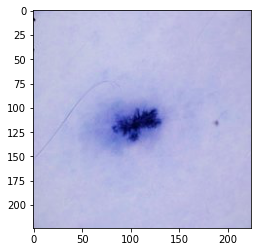

In [7]:
plt.imshow(X[0])

In [6]:
y = pd.DataFrame(y)
y.value_counts()

0    1800
1    1800
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

X_trai, X_tet, y_trai, y_tet = train_test_split(X, y, test_size=0.20,random_state=1,shuffle=True)

In [7]:
X_trai = X_trai/255
X_tet = X_tet/255

In [9]:
X_trai[0]

array([[[0.63137255, 0.61176471, 0.78823529],
        [0.63137255, 0.61176471, 0.78823529],
        [0.63137255, 0.61176471, 0.78823529],
        ...,
        [0.45490196, 0.51372549, 0.78431373],
        [0.46666667, 0.5254902 , 0.79607843],
        [0.48627451, 0.54509804, 0.81568627]],

       [[0.63529412, 0.61568627, 0.79215686],
        [0.63529412, 0.61568627, 0.79215686],
        [0.63529412, 0.61568627, 0.79215686],
        ...,
        [0.46666667, 0.5254902 , 0.79607843],
        [0.46666667, 0.5254902 , 0.79607843],
        [0.48235294, 0.54117647, 0.81176471]],

       [[0.63137255, 0.61568627, 0.78039216],
        [0.63137255, 0.61568627, 0.78039216],
        [0.63137255, 0.61568627, 0.78039216],
        ...,
        [0.49019608, 0.54901961, 0.81960784],
        [0.48235294, 0.54117647, 0.81176471],
        [0.48627451, 0.54509804, 0.81568627]],

       ...,

       [[0.68627451, 0.67058824, 0.76862745],
        [0.68627451, 0.67058824, 0.76862745],
        [0.68627451, 0

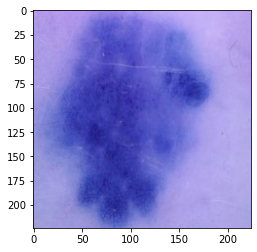

In [11]:
plt.imshow(X_trai[9])

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
pre_trained_model = tf.keras.applications.InceptionV3(include_top=False,
                                                        input_shape=(224, 224, 3),
                                                        weights="imagenet"
                                                        )

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
print('layers ',len(pre_trained_model.layers))

for layer in pre_trained_model.layers[:0]:
    layer.trainable = False
       #print(layer.name, ' trainable: ', layer.trainable)
for layer in pre_trained_model.layers[1:]:
    layer.trainable = True
     
model = tf.keras.models.Sequential([
    pre_trained_model,
    layers.Conv2D(filters= 32, kernel_size = [3,5]),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

layers  311
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 3, 1, 32)          983072    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)    

In [12]:
model.evaluate(X_tet,y_tet)

23/23 [==============================] - 67s 3s/step - loss: 0.5863 - accuracy: 0.8986


[0.586276650428772, 0.8986111283302307]

In [13]:
from sklearn.metrics import accuracy_score

In [15]:
y_pred = model.predict(X_tet)

In [14]:
from sklearn import metrics

In [18]:
res = pd.DataFrame(columns=["Accuracy", 
                            "Precision", 
                            "Recall", 
                            "F1Score"])

ypred = model.predict(X_tet)
y_pred = np.round(abs(ypred))
pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_tet, y_pred, average='macro')
res = res.append({"Accuracy": round(metrics.accuracy_score(y_tet, y_pred), 4),"Precision": round(pr, 4), "Recall":round(rc, 4), "F1Score":round(fs, 4),}, ignore_index=True)
res.set_index("Accuracy", inplace=True)
res.sort_values(by="Accuracy", ascending=False, inplace=True)   
print(res)

          Precision  Recall  F1Score
Accuracy                            
0.8986       0.8986  0.8985   0.8986


In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
confusion_matrix(y_tet, np.round(abs(y_pred)))

array([[331,  36],
       [ 37, 316]], dtype=int64)

In [9]:
from tensorflow.keras.applications.vgg19 import VGG19

In [10]:
pre_trained_model1 = tf.keras.applications.VGG19(include_top=False,
                                                        input_shape=(224, 224, 3),
                                                        weights="imagenet"
                                                        )

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
print('layers ',len(pre_trained_model1.layers))
#the first layer is the input
for layer in pre_trained_model1.layers:
    layer.trainable = False

model1 = tf.keras.models.Sequential([
    pre_trained_model1,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

layers  22
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)       

In [11]:
history1 = model1.fit(X_trai, y_trai, validation_data=(X_tet, y_tet),
                   epochs = 10,
                   batch_size = 32,
                   verbose = 1)

Epoch 1/10
90/90 [==============================] - 1204s 13s/step - loss: 0.7439 - accuracy: 0.5035 - val_loss: 0.6700 - val_accuracy: 0.6528
Epoch 2/10
90/90 [==============================] - 1129s 13s/step - loss: 0.7039 - accuracy: 0.5580 - val_loss: 0.6470 - val_accuracy: 0.7097
Epoch 3/10
90/90 [==============================] - 903s 10s/step - loss: 0.6817 - accuracy: 0.5726 - val_loss: 0.6208 - val_accuracy: 0.7611
Epoch 4/10
90/90 [==============================] - 901s 10s/step - loss: 0.6435 - accuracy: 0.6306 - val_loss: 0.5852 - val_accuracy: 0.7722
Epoch 5/10
90/90 [==============================] - 897s 10s/step - loss: 0.6282 - accuracy: 0.6472 - val_loss: 0.5597 - val_accuracy: 0.7708
Epoch 6/10
90/90 [==============================] - 3910s 43s/step - loss: 0.5999 - accuracy: 0.6847 - val_loss: 0.5346 - val_accuracy: 0.7694
Epoch 7/10
90/90 [==============================] - 866s 10s/step - loss: 0.5695 - accuracy: 0.7167 - val_loss: 0.5138 - val_accuracy: 0.7611
Epo

In [12]:
y_pred1 = model1.predict(X_tet)

In [16]:
confusion_matrix(y_tet, np.round(abs(y_pred1)))

array([[294,  73],
       [ 89, 264]], dtype=int64)

In [17]:
res = pd.DataFrame(columns=["Accuracy", 
                            "Precision", 
                            "Recall", 
                            "F1Score"])

ypred1 = model1.predict(X_tet)
y_pred1 = np.round(abs(ypred1))
pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_tet, y_pred1, average='macro')
res = res.append({"Accuracy": round(metrics.accuracy_score(y_tet, y_pred1), 4),"Precision": round(pr, 4), "Recall":round(rc, 4), "F1Score":round(fs, 4),}, ignore_index=True)
res.set_index("Accuracy", inplace=True)
res.sort_values(by="Accuracy", ascending=False, inplace=True)   
print(res)

          Precision  Recall  F1Score
Accuracy                            
0.775        0.7755  0.7745   0.7746


In [9]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [18]:
pre_trained_model3 = tf.keras.applications.MobileNetV2(include_top=False,
                                                        input_shape=(224, 224, 3),
                                                        weights="imagenet"
                                                        )

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
print('layers ',len(pre_trained_model3.layers))
#the first layer is the input
for layer in pre_trained_model3.layers[:0]:
    layer.trainable = False
       #print(layer.name, ' trainable: ', layer.trainable)
for layer in pre_trained_model3.layers[1:]:
    layer.trainable = True
        #print(layer.name, ' trainable: ', layer.trainable)

model3 = tf.keras.models.Sequential([
    pre_trained_model3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

layers  155
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)    

In [10]:
pre_trained_model3 = tf.keras.applications.MobileNetV2(include_top=False,
                                                        input_shape=(224, 224, 3),
                                                        weights="imagenet"
                                                        )

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
print('layers ',len(pre_trained_model3.layers))
#the first layer is the input
for layer in pre_trained_model3.layers:
    layer.trainable = False

model3 = tf.keras.models.Sequential([
    pre_trained_model3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

layers  155
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)      

In [11]:
history3 = model3.fit(X_trai, y_trai, validation_data=(X_tet, y_tet),
                   epochs = 10,
                   batch_size = 32,
                   verbose = 1)

Epoch 1/10
90/90 [==============================] - 120s 1s/step - loss: 0.7616 - accuracy: 0.5611 - val_loss: 0.5367 - val_accuracy: 0.7792
Epoch 2/10
90/90 [==============================] - 111s 1s/step - loss: 0.5777 - accuracy: 0.6972 - val_loss: 0.4652 - val_accuracy: 0.8167
Epoch 3/10
90/90 [==============================] - 119s 1s/step - loss: 0.5087 - accuracy: 0.7573 - val_loss: 0.4347 - val_accuracy: 0.8083
Epoch 4/10
90/90 [==============================] - 113s 1s/step - loss: 0.4631 - accuracy: 0.7906 - val_loss: 0.4169 - val_accuracy: 0.8083
Epoch 5/10
90/90 [==============================] - 113s 1s/step - loss: 0.4431 - accuracy: 0.7941 - val_loss: 0.4019 - val_accuracy: 0.8167
Epoch 6/10
90/90 [==============================] - 113s 1s/step - loss: 0.4152 - accuracy: 0.8111 - val_loss: 0.3859 - val_accuracy: 0.8167
Epoch 7/10
90/90 [==============================] - 113s 1s/step - loss: 0.4109 - accuracy: 0.8160 - val_loss: 0.3752 - val_accuracy: 0.8194
Epoch 8/10
90

In [12]:
y_pred3 = model3.predict(X_tet)

In [16]:
confusion_matrix(y_tet, np.round(abs(y_pred3)))

array([[293,  74],
       [ 48, 305]], dtype=int64)

In [18]:
res = pd.DataFrame(columns=["Accuracy", 
                            "Precision", 
                            "Recall", 
                            "F1Score"])

ypred3 = model3.predict(X_tet)
y_pred3 = np.round(abs(ypred3))
pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_tet, y_pred3, average='macro')
res = res.append({"Accuracy": round(metrics.accuracy_score(y_tet, y_pred3), 4),"Precision": round(pr, 4), "Recall":round(rc, 4), "F1Score":round(fs, 4),}, ignore_index=True)
res.set_index("Accuracy", inplace=True)
res.sort_values(by="Accuracy", ascending=False, inplace=True)   
print(res)

          Precision  Recall  F1Score
Accuracy                            
0.8306        0.832  0.8312   0.8305


In [19]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [21]:
pre_trained_model5 = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False,
                                                        input_shape=(224, 224, 3),
                                                        weights="imagenet"
                                                        )

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
print('layers ',len(pre_trained_model5.layers))
#the first layer is the input
for layer in pre_trained_model5.layers:
    layer.trainable = False
model5 = tf.keras.models.Sequential([
    pre_trained_model5,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model5.summary()

layers  813
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2560)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               655616    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)    

In [22]:
history5 = model5.fit(X_trai, y_trai, validation_data=(X_tet, y_tet),
                   epochs = 10,
                   batch_size = 32,
                   verbose = 1)

Epoch 1/10
90/90 [==============================] - 1328s 15s/step - loss: 0.7046 - accuracy: 0.5038 - val_loss: 0.6934 - val_accuracy: 0.4903
Epoch 2/10
90/90 [==============================] - 1075s 12s/step - loss: 0.6990 - accuracy: 0.4958 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 3/10
90/90 [==============================] - 1071s 12s/step - loss: 0.6986 - accuracy: 0.4972 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 4/10
90/90 [==============================] - 1268s 14s/step - loss: 0.6974 - accuracy: 0.4979 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 5/10
90/90 [==============================] - 1192s 13s/step - loss: 0.6951 - accuracy: 0.5153 - val_loss: 0.6932 - val_accuracy: 0.4903
Epoch 6/10
90/90 [==============================] - 1205s 13s/step - loss: 0.6964 - accuracy: 0.4990 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 7/10
90/90 [==============================] - 3815s 42s/step - loss: 0.6968 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.5097

In [23]:
y_pred5 = model5.predict(X_tet)

In [24]:
confusion_matrix(y_tet, np.round(abs(y_pred5)))

array([[  0, 367],
       [  0, 353]], dtype=int64)

In [25]:
res = pd.DataFrame(columns=["Accuracy", 
                            "Precision", 
                            "Recall", 
                            "F1Score"])

ypred5 = model5.predict(X_tet)
y_pred5 = np.round(abs(ypred5))
pr, rc, fs, sup = metrics.precision_recall_fscore_support(y_tet, y_pred5, average='macro')
res = res.append({"Accuracy": round(metrics.accuracy_score(y_tet, y_pred5), 4),"Precision": round(pr, 4), "Recall":round(rc, 4), "F1Score":round(fs, 4),}, ignore_index=True)
res.set_index("Accuracy", inplace=True)
res.sort_values(by="Accuracy", ascending=False, inplace=True)   
print(res)

          Precision  Recall  F1Score
Accuracy                            
0.4903       0.2451     0.5    0.329


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
